In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
api = wandb.Api()

def linearize_dict(d, parent_key='', sep='.'):
    """
    Linearizes a nested dictionary into a flat dictionary with keys in the format `key1.key2`.

    :param d: The dictionary to linearize.
    :param parent_key: The current key being processed (used for recursion).
    :param sep: The separator between keys.
    :return: A flattened dictionary.
    """
    items = []
    
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(linearize_dict(v, new_key, sep).items())
        else:
            items.append((new_key, v))
    
    return dict(items)

def get_filtered_df(runs_df, prompt_images, prompt_images_col):
    cols = ["model.name", "/MulticlassJaccardIndex_fg", prompt_images_col, "model.backbone", "refinement.lr"]
    mask = runs_df[prompt_images_col].isin(prompt_images)
    filtered_df = runs_df[cols][mask]
    print(f"Filtered {len(filtered_df)} runs")
    # Replace NaN values in "model.backbone" with values from "model.params.teacher.backbone"
    filtered_df['model.backbone'] = filtered_df['model.backbone'].fillna(runs_df['model.params.teacher.backbone'])

    # Change model.name to TransferFSS when refinement.lr is not NaN and model.name is dcama
    filtered_df['model.name'] = filtered_df.apply(
        lambda row: 'TransferFSS' if row['model.name'] == 'dcama' and pd.notna(row['refinement.lr']) else row['model.name'],
        axis=1
    )
    # rename values in model.name
    filtered_df['model.name'] = filtered_df['model.name'].replace({
        'bam': 'BAM',
        'hdmnet': 'HDMNet',
        'distillator': 'DistillFSS',
        "few_distiller": "DistillFSS",
        'dcama': 'DCAMA',
        'patnet': 'PATNet',
        'dmtnet': 'DMTNet',
    })

    # rename values in model.backbone
    filtered_df['model.backbone'] = filtered_df['model.backbone'].replace({
        'resnet': 'ResNet-18',
        'resnet50': 'ResNet-50',
        'swin': 'Swin-B',
    })
    # fill-na with ResNet-50
    filtered_df['model.backbone'] = filtered_df['model.backbone'].fillna('ResNet-50')

    # Append model.backbone to model.name where model.backbone is not NaN
    filtered_df['Full Name'] = filtered_df.apply(
        lambda row: f"{row['model.name']} ({row['model.backbone']})" if pd.notna(row['model.backbone']) else row['model.name'],
        axis=1
    )

    ordering = [ 
        "BAM (ResNet-50)",
        "HDMNet (ResNet-50)",
        "PATNet (ResNet-50)",
        "DMTNet (ResNet-50)",
        "DCAMA (ResNet-50)",
        "DCAMA (Swin-B)",
        "TransferFSS (ResNet-50)",
        "TransferFSS (Swin-B)",
        "DistillFSS (ResNet-50)",
        "DistillFSS (Swin-B)"
    ]
    filtered_df = filtered_df.sort_values(by='Full Name', key=lambda x: x.map(lambda name: ordering.index(name)))


    filtered_df.drop(columns=['refinement.lr'], inplace=True)
    return filtered_df

def get_results_and_fig(dataset, filtered_df, prompt_images_col):
    # round and multiply by 100 /MulticlassJaccardIndex_fg
    filtered_df['/MulticlassJaccardIndex_fg'] = filtered_df['/MulticlassJaccardIndex_fg'].round(4) * 100

    # Group by model.name and prompt_images, then get the best Jaccard Index for each group
    best_rows = filtered_df.loc[filtered_df.groupby(['Full Name', prompt_images_col])['/MulticlassJaccardIndex_fg'].idxmax()]

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Loop through each model and plot the best Jaccard Index for each prompt image
    for model_name, group in best_rows.groupby('Full Name'):
        plt.plot(group[prompt_images_col], group['/MulticlassJaccardIndex_fg'], label=model_name, marker='o')

    # Set labels and title
    plt.xlabel('Prompt Images')
    plt.ylabel('Multiclass Jaccard Index')
    plt.title('Best Jaccard Index for Each Model by Prompt Image')

    # Add a legend
    plt.legend(title='Model')

    # Show the plot
    plt.show()
    # Create a pivot table with model.name as rows and prompt_images_col as columns
    pivot_df = best_rows.pivot(index=['model.name', 'model.backbone'], columns=prompt_images_col, values='/MulticlassJaccardIndex_fg')
    # Sort the pivot table by model.name and model.backbone
    ordering = [
        "BAM", "HDMNet", "PATNet", "DMTNet", "DCAMA", "TransferFSS", "DistillFSS"
    ]
    backbone_ordering = [
        "ResNet-18", "ResNet-50", "Swin-B"
    ]

    pivot_df = pivot_df.sort_index(level=['model.name', 'model.backbone'], key=lambda x: x.map(lambda name: ordering.index(name) if name in ordering else len(ordering)))

    # Rename the columns
    pivot_df.index.names = ['Model', 'Backbone']
    pivot_df.columns.name = 'Support set lenght'

    pivot_df.to_csv(f"results/{dataset}.csv")

    return pivot_df

def get_runs(filters):
    runs = api.runs("pasqualedem/FSSWeed", filters=filters)
    runs_list = []
    for run in runs: 
        runs_list.append({
            **run.summary._json_dict,
            **linearize_dict({k: v for k,v in run.config.items()
            if not k.startswith('_')}),
            **{"name": run.name}
            })

    runs_df = pd.DataFrame(runs_list)
    return runs_df

In [2]:
results = {}
filtered_dfs = {}
pivots = {}

### ISIC

In [3]:
dataset = "ISIC"

prompt_images_col = f'dataset.datasets.test_{dataset.lower()}.prompt_images'
filters = {
  "group": dataset
}
prompt_images = [9, 15, 30, 60]

results[dataset] = get_runs(filters)
results[dataset].head()

,/MulticlassF1Score,/MulticlassF1Score_background,/MulticlassF1Score_melanoma,/MulticlassF1Score_nevus,/MulticlassF1Score_seborrheic_keratosis,/MulticlassJaccardIndex,/MulticlassJaccardIndex_background,/MulticlassJaccardIndex_melanoma,/MulticlassJaccardIndex_nevus,/MulticlassJaccardIndex_seborrheic_keratosis,...,model.params.student.name,model.params.student.num_classes,model.params.teacher.name,model.params.teacher.backbone,model.params.teacher.image_size,model.params.teacher.concat_support,model.params.teacher.model_checkpoint,model.params.teacher.backbone_checkpoint,tracker.cache_dir,model.voting
0,0.405632,0.908383,0.187643,0.526504,0.0,0.323249,0.832144,0.103535,0.357316,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.313304,0.906626,0.284488,0.062102,0.0,0.256770,0.829200,0.165833,0.032046,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.408010,0.929935,0.219564,0.482541,0.0,0.327590,0.869046,0.123320,0.317992,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.376277,0.939811,0.144277,0.421022,0.0,0.307711,0.886455,0.077747,0.266642,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.390265,0.947423,0.158913,0.454724,0.0,0.320170,0.900098,0.086315,0.294267,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
filtered_df = get_filtered_df(results[dataset], prompt_images, prompt_images_col)
filtered_dfs[dataset] = filtered_df
filtered_df

Filtered 84 runs


,model.name,/MulticlassJaccardIndex_fg,dataset.datasets.test_isic.prompt_images,model.backbone,Full Name
102,BAM,0.086919,60,ResNet-50,BAM (ResNet-50)
90,BAM,0.096669,9,ResNet-50,BAM (ResNet-50)
100,BAM,0.084686,30,ResNet-50,BAM (ResNet-50)
98,BAM,0.083405,15,ResNet-50,BAM (ResNet-50)
99,HDMNet,0.078203,15,ResNet-50,HDMNet (ResNet-50)
...,...,...,...,...,...
79,DistillFSS,0.176861,30,Swin-B,DistillFSS (Swin-B)
78,DistillFSS,0.135276,15,Swin-B,DistillFSS (Swin-B)
77,DistillFSS,0.156326,15,Swin-B,DistillFSS (Swin-B)
84,DistillFSS,0.216855,60,Swin-B,DistillFSS (Swin-B)


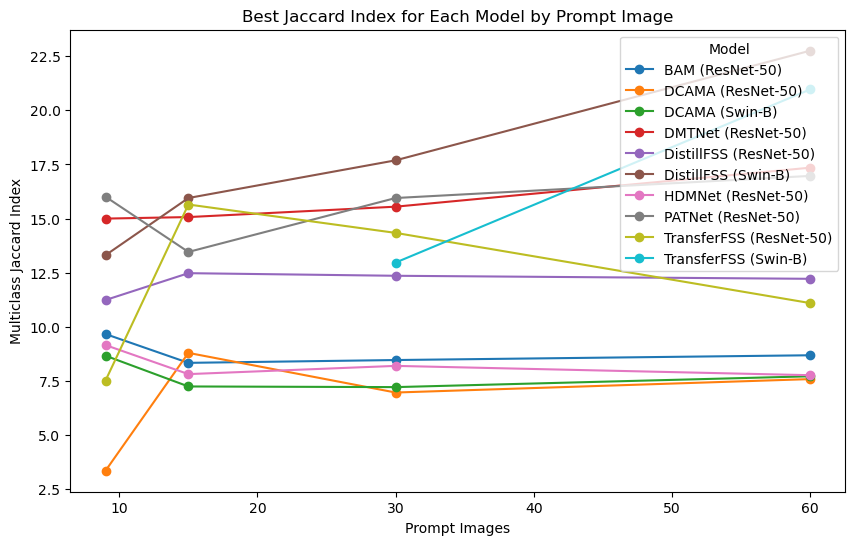

Support set lenght        9      15     30     60
Model       Backbone                             
BAM         ResNet-50   9.67   8.34   8.47   8.69
HDMNet      ResNet-50   9.16   7.82   8.20   7.77
PATNet      ResNet-50  16.01  13.46  15.95  16.97
DMTNet      ResNet-50  15.00  15.07  15.55  17.35
DCAMA       ResNet-50   3.36   8.80   6.97   7.59
            Swin-B      8.67   7.25   7.22   7.72
TransferFSS ResNet-50   7.52  15.65  14.34  11.10
            Swin-B       NaN    NaN  12.97  20.96
DistillFSS  ResNet-50  11.24  12.48  12.36  12.22
            Swin-B     13.31  15.95  17.69  22.75

In [5]:
pivot_df = get_results_and_fig(dataset, filtered_df, prompt_images_col)
pivots[dataset] = pivot_df
pivot_df

### Nucleus

In [6]:
dataset = "Nucleus"

prompt_images_col = f'dataset.datasets.test_{dataset.lower()}.prompt_images'
filters = {
  "group": dataset
}
prompt_images = [5, 10, 25, 50]

results[dataset] = get_runs(filters)
results[dataset].head()

,/MulticlassF1Score,/MulticlassF1Score_background,/MulticlassF1Score_fg,/MulticlassF1Score_nucleus,/MulticlassJaccardIndex,/MulticlassJaccardIndex_background,/MulticlassJaccardIndex_fg,/MulticlassJaccardIndex_nucleus,/MulticlassPrecision,/MulticlassPrecision_background,...,model.params.student.name,model.params.student.num_classes,model.params.teacher.name,model.params.teacher.backbone,model.params.teacher.image_size,model.params.teacher.concat_support,model.params.teacher.model_checkpoint,model.params.teacher.backbone_checkpoint,model.voting,tracker.cache_dir
0,0.915195,0.975255,0.855135,0.855135,0.849319,0.951706,0.746931,0.746931,0.926276,0.970131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.606783,0.917080,0.296487,0.296487,0.510451,0.846858,0.174044,0.174044,0.695032,0.873197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.498656,0.643131,0.354180,0.354180,0.344591,0.473982,0.215200,0.215200,0.584517,0.944505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.912869,0.975098,0.850640,0.850640,0.845753,0.951407,0.740099,0.740099,0.932213,0.966634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.902703,0.968218,0.837189,0.837189,0.829182,0.938393,0.719970,0.719970,0.879606,0.983407,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
filtered_df = get_filtered_df(results[dataset], prompt_images, prompt_images_col)
filtered_dfs[dataset] = filtered_df
filtered_df

Filtered 108 runs


,model.name,/MulticlassJaccardIndex_fg,dataset.datasets.test_nucleus.prompt_images,model.backbone,Full Name
88,BAM,0.110457,50,ResNet-50,BAM (ResNet-50)
101,BAM,0.113240,10,ResNet-50,BAM (ResNet-50)
95,BAM,0.110265,5,ResNet-50,BAM (ResNet-50)
96,BAM,0.120716,25,ResNet-50,BAM (ResNet-50)
94,HDMNet,0.211704,25,ResNet-50,HDMNet (ResNet-50)
...,...,...,...,...,...
53,DistillFSS,0.650436,50,Swin-B,DistillFSS (Swin-B)
69,DistillFSS,0.638546,25,Swin-B,DistillFSS (Swin-B)
70,DistillFSS,0.645858,5,Swin-B,DistillFSS (Swin-B)
50,DistillFSS,0.711560,10,Swin-B,DistillFSS (Swin-B)


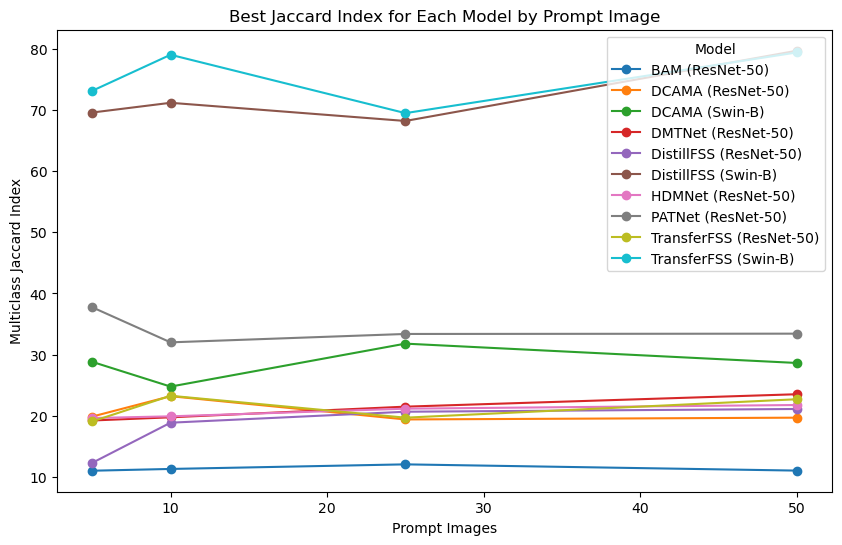

Support set lenght        5      10     25     50
Model       Backbone                             
BAM         ResNet-50  11.03  11.32  12.07  11.05
HDMNet      ResNet-50  19.64  19.92  21.17  21.77
PATNet      ResNet-50  37.74  32.01  33.38  33.43
DMTNet      ResNet-50  19.24  19.76  21.50  23.53
DCAMA       ResNet-50  19.88  23.21  19.41  19.70
            Swin-B     28.82  24.78  31.80  28.64
TransferFSS ResNet-50  19.09  23.28  19.70  22.71
            Swin-B     73.12  79.01  69.47  79.39
DistillFSS  ResNet-50  12.32  18.88  20.67  21.12
            Swin-B     69.57  71.16  68.19  79.67

In [8]:
pivot_df = get_results_and_fig(dataset, filtered_df, prompt_images_col)
pivots[dataset] = pivot_df
pivot_df

### Lung

In [9]:
dataset = "LungCancer"

prompt_images_col = f'dataset.datasets.test_{dataset.lower()}.prompt_images'
filters = {
  "group": dataset
}
prompt_images = [5, 10, 25, 50]

results[dataset] = get_runs(filters)
results[dataset].head()

,/MulticlassF1Score,/MulticlassF1Score_background,/MulticlassF1Score_fg,/MulticlassF1Score_nodule,/MulticlassJaccardIndex,/MulticlassJaccardIndex_background,/MulticlassJaccardIndex_fg,/MulticlassJaccardIndex_nodule,/MulticlassPrecision,/MulticlassPrecision_background,...,model.model_checkpoint,model.backbone,model.image_size,model.concat_support,model.backbone_checkpoint,model.shots,model.params.student.use_support,model.pe,tracker.cache_dir,model.voting
0,0.499629,0.999258,0.000000,0.000000,0.499259,0.998518,0.000000,0.000000,0.499556,0.999112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.508033,0.998991,0.017075,0.017075,0.503297,0.997983,0.008611,0.008611,0.507085,0.999129,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.506051,0.989461,0.022640,0.022640,0.495296,0.979143,0.011450,0.011450,0.505576,0.999341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.545012,0.997141,0.092884,0.092884,0.521501,0.994298,0.048704,0.048704,0.526739,0.999401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.371702,0.740110,0.003295,0.003295,0.294545,0.587440,0.001650,0.001650,0.500650,0.999650,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
filtered_df = get_filtered_df(results[dataset], prompt_images, prompt_images_col)
filtered_dfs[dataset] = filtered_df
filtered_df

Filtered 104 runs


,model.name,/MulticlassJaccardIndex_fg,dataset.datasets.test_lungcancer.prompt_images,model.backbone,Full Name
4,BAM,0.001650,5,ResNet-50,BAM (ResNet-50)
32,BAM,0.001867,50,ResNet-50,BAM (ResNet-50)
30,BAM,0.001988,25,ResNet-50,BAM (ResNet-50)
11,BAM,0.001692,10,ResNet-50,BAM (ResNet-50)
33,HDMNet,0.001587,50,ResNet-50,HDMNet (ResNet-50)
...,...,...,...,...,...
18,DistillFSS,0.000009,50,Swin-B,DistillFSS (Swin-B)
19,DistillFSS,0.024752,25,Swin-B,DistillFSS (Swin-B)
20,DistillFSS,0.005141,25,Swin-B,DistillFSS (Swin-B)
39,DistillFSS,0.015920,5,Swin-B,DistillFSS (Swin-B)


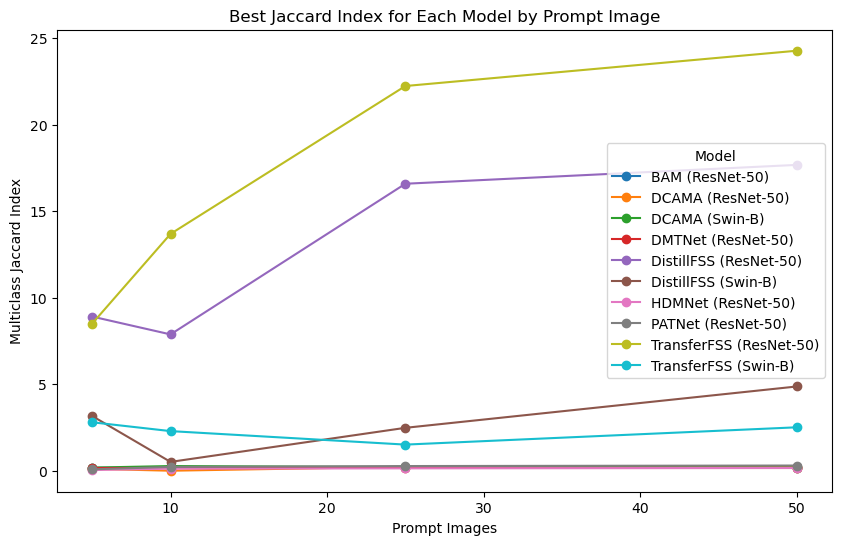

Support set lenght       5      10     25     50
Model       Backbone                            
BAM         ResNet-50  0.17   0.17   0.20   0.19
HDMNet      ResNet-50  0.04   0.12   0.14   0.16
PATNet      ResNet-50  0.08   0.22   0.27   0.30
DMTNet      ResNet-50  0.16   0.16   0.16   0.16
DCAMA       ResNet-50  0.11   0.00   0.23   0.24
            Swin-B     0.18   0.27   0.21   0.18
TransferFSS ResNet-50  8.51  13.69  22.24  24.28
            Swin-B     2.80   2.29   1.51   2.51
DistillFSS  ResNet-50  8.91   7.88  16.59  17.68
            Swin-B     3.16   0.51   2.48   4.87

In [11]:
pivot_df = get_results_and_fig(dataset, filtered_df, prompt_images_col)
pivots[dataset] = pivot_df
pivot_df

### WeedMap

In [12]:
dataset = "WeedMap"

prompt_images_col = f'dataset.datasets.test_{dataset.lower()}.prompt_images'
filters = {
  "group": dataset
}
prompt_images = [5, 10, 25, 50]

results[dataset] = get_runs(filters)
results[dataset].head()

,/MulticlassF1Score,/MulticlassF1Score_background,/MulticlassF1Score_crop,/MulticlassF1Score_fg,/MulticlassF1Score_weed,/MulticlassJaccardIndex,/MulticlassJaccardIndex_background,/MulticlassJaccardIndex_crop,/MulticlassJaccardIndex_fg,/MulticlassJaccardIndex_weed,...,refinement.lr,refinement.loss.name,refinement.loss.gamma,refinement.subsample,refinement.substitutor,refinement.hot_parameters,refinement.max_iterations,tracker.cache_dir,model.voting,refinement.iterations_is_num_classes
0,0.343813,0.878065,0.061882,0.076687,0.091492,0.287501,0.782634,0.031929,0.039934,0.047939,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.224672,0.556519,0.111347,0.058749,0.006152,0.149193,0.385539,0.058956,0.031021,0.003085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.352422,0.864484,0.166072,0.096392,0.026712,0.288469,0.761314,0.090555,0.052046,0.013537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.268698,0.624093,0.115107,0.091001,0.066895,0.183087,0.453587,0.061068,0.047836,0.034605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.323260,0.893128,0.043216,0.038327,0.033437,0.281994,0.806893,0.022085,0.019544,0.017003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
filtered_df = get_filtered_df(results[dataset], prompt_images, prompt_images_col)
filtered_dfs[dataset] = filtered_df
filtered_df

Filtered 39 runs


,model.name,/MulticlassJaccardIndex_fg,dataset.datasets.test_weedmap.prompt_images,model.backbone,Full Name
106,PATNet,0.069583,50,ResNet-50,PATNet (ResNet-50)
115,PATNet,0.069481,25,ResNet-50,PATNet (ResNet-50)
114,PATNet,0.063024,10,ResNet-50,PATNet (ResNet-50)
109,DMTNet,0.021716,10,ResNet-50,DMTNet (ResNet-50)
107,DMTNet,0.024019,25,ResNet-50,DMTNet (ResNet-50)
111,DMTNet,0.022973,50,ResNet-50,DMTNet (ResNet-50)
105,DCAMA,0.051108,10,ResNet-50,DCAMA (ResNet-50)
113,DCAMA,0.050133,50,ResNet-50,DCAMA (ResNet-50)
110,DCAMA,0.049013,25,ResNet-50,DCAMA (ResNet-50)
112,DCAMA,0.037849,50,Swin-B,DCAMA (Swin-B)


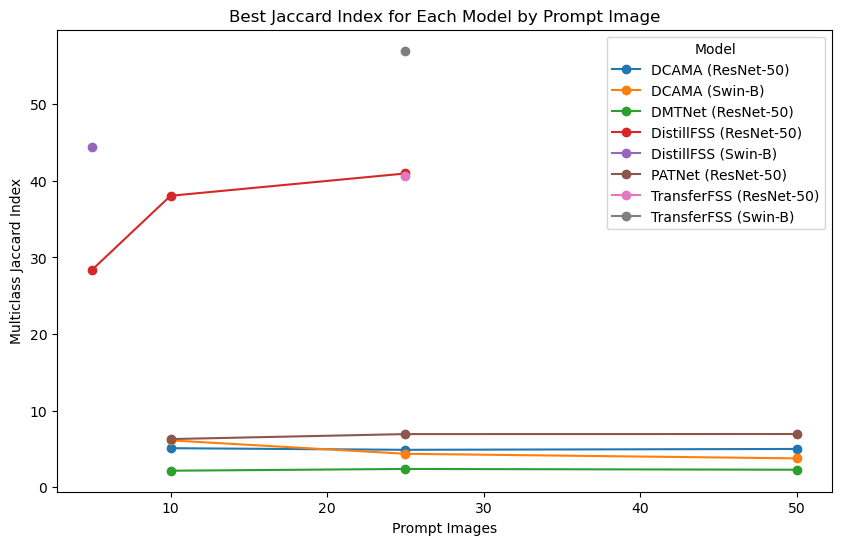

Support set lenght        5      10     25    50
Model       Backbone                            
PATNet      ResNet-50    NaN   6.30   6.95  6.96
DMTNet      ResNet-50    NaN   2.17   2.40  2.30
DCAMA       ResNet-50    NaN   5.11   4.90  5.01
            Swin-B       NaN   6.13   4.38  3.78
TransferFSS ResNet-50    NaN    NaN  40.61   NaN
            Swin-B       NaN    NaN  56.98   NaN
DistillFSS  ResNet-50  28.41  38.05  40.96   NaN
            Swin-B     44.43    NaN    NaN   NaN

In [14]:
pivot_df = get_results_and_fig(dataset, filtered_df, prompt_images_col)
pivots[dataset] = pivot_df
pivot_df

### Pothole

In [15]:
dataset = "Pothole"

prompt_images_col = f'dataset.datasets.test_{dataset.lower()}.prompt_images'
filters = {
  "group": dataset
}
prompt_images = [5, 10, 25, 50]

results[dataset] = get_runs(filters)
results[dataset].head()

,/MulticlassF1Score,/MulticlassF1Score_background,/MulticlassF1Score_fg,/MulticlassF1Score_pothole,/MulticlassJaccardIndex,/MulticlassJaccardIndex_background,/MulticlassJaccardIndex_fg,/MulticlassJaccardIndex_pothole,/MulticlassPrecision,/MulticlassPrecision_background,...,model.params.teacher.name,model.params.teacher.backbone,model.params.teacher.image_size,model.params.teacher.concat_support,model.params.teacher.model_checkpoint,model.params.teacher.backbone_checkpoint,tracker.mode,tracker.cache_dir,tracker.offline_directory,model.voting
0,0.640222,0.976372,0.304072,0.304072,0.566565,0.953834,0.179296,0.179296,0.728160,0.963853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.612364,0.971922,0.252806,0.252806,0.545035,0.945378,0.144693,0.144693,0.650711,0.962749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.640337,0.974484,0.306191,0.306191,0.565504,0.950237,0.180771,0.180771,0.694865,0.964557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.591771,0.970621,0.212921,0.212921,0.531032,0.942919,0.119145,0.119145,0.624805,0.961233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.642383,0.972401,0.312364,0.312364,0.565687,0.946285,0.185090,0.185090,0.672447,0.965560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
filtered_df = get_filtered_df(results[dataset], prompt_images, prompt_images_col)
filtered_dfs[dataset] = filtered_df
filtered_df

Filtered 125 runs


,model.name,/MulticlassJaccardIndex_fg,dataset.datasets.test_pothole.prompt_images,model.backbone,Full Name
130,BAM,0.022313,50,ResNet-50,BAM (ResNet-50)
51,BAM,0.009034,50,ResNet-50,BAM (ResNet-50)
127,BAM,0.039022,25,ResNet-50,BAM (ResNet-50)
49,BAM,0.014789,25,ResNet-50,BAM (ResNet-50)
78,BAM,0.014615,5,ResNet-50,BAM (ResNet-50)
...,...,...,...,...,...
27,DistillFSS,0.131969,10,Swin-B,DistillFSS (Swin-B)
26,DistillFSS,0.158590,10,Swin-B,DistillFSS (Swin-B)
38,DistillFSS,0.144698,25,Swin-B,DistillFSS (Swin-B)
41,DistillFSS,0.139772,25,Swin-B,DistillFSS (Swin-B)


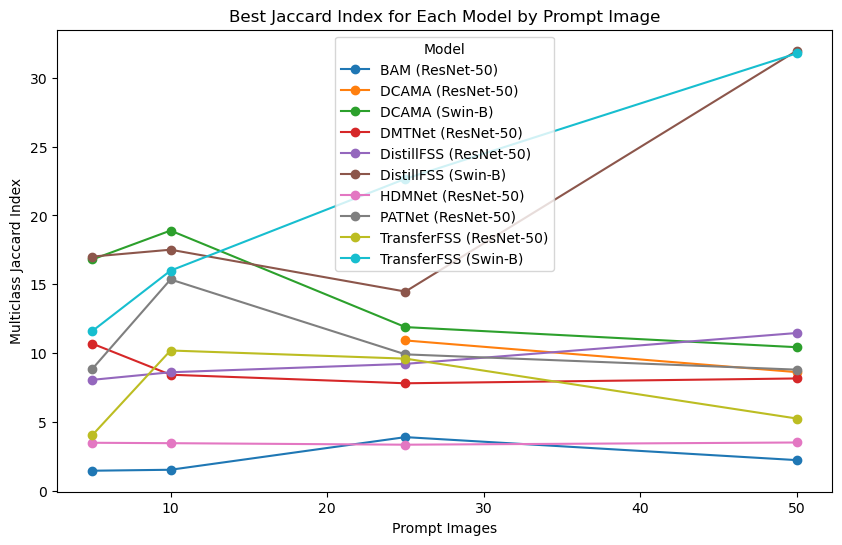

Support set lenght        5      10     25     50
Model       Backbone                             
BAM         ResNet-50   1.46   1.53   3.90   2.23
HDMNet      ResNet-50   3.49   3.46   3.35   3.51
PATNet      ResNet-50   8.85  15.35   9.91   8.80
DMTNet      ResNet-50  10.69   8.43   7.81   8.16
DCAMA       ResNet-50    NaN    NaN  10.92   8.62
            Swin-B     16.80  18.90  11.89  10.43
TransferFSS ResNet-50   4.04  10.19   9.60   5.25
            Swin-B     11.60  15.99  22.66  31.77
DistillFSS  ResNet-50   8.06   8.61   9.22  11.46
            Swin-B     17.01  17.51  14.47  31.96

In [17]:
pivot_df = get_results_and_fig(dataset, filtered_df, prompt_images_col)
pivots[dataset] = pivot_df
pivot_df

### KVASIR

In [18]:
dataset = "Pothole"

prompt_images_col = f'dataset.datasets.test_{dataset.lower()}.prompt_images'
filters = {
  "group": dataset
}
prompt_images = [5, 10, 25, 50]

results[dataset] = get_runs(filters)
results[dataset].head()

,/MulticlassF1Score,/MulticlassF1Score_background,/MulticlassF1Score_fg,/MulticlassF1Score_pothole,/MulticlassJaccardIndex,/MulticlassJaccardIndex_background,/MulticlassJaccardIndex_fg,/MulticlassJaccardIndex_pothole,/MulticlassPrecision,/MulticlassPrecision_background,...,model.params.teacher.name,model.params.teacher.backbone,model.params.teacher.image_size,model.params.teacher.concat_support,model.params.teacher.model_checkpoint,model.params.teacher.backbone_checkpoint,tracker.mode,tracker.cache_dir,tracker.offline_directory,model.voting
0,0.640222,0.976372,0.304072,0.304072,0.566565,0.953834,0.179296,0.179296,0.728160,0.963853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.612364,0.971922,0.252806,0.252806,0.545035,0.945378,0.144693,0.144693,0.650711,0.962749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.640337,0.974484,0.306191,0.306191,0.565504,0.950237,0.180771,0.180771,0.694865,0.964557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.591771,0.970621,0.212921,0.212921,0.531032,0.942919,0.119145,0.119145,0.624805,0.961233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.642383,0.972401,0.312364,0.312364,0.565687,0.946285,0.185090,0.185090,0.672447,0.965560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
filtered_df = get_filtered_df(results[dataset], prompt_images, prompt_images_col)
filtered_dfs[dataset] = filtered_df
filtered_df

Filtered 125 runs


,model.name,/MulticlassJaccardIndex_fg,dataset.datasets.test_pothole.prompt_images,model.backbone,Full Name
130,BAM,0.022313,50,ResNet-50,BAM (ResNet-50)
51,BAM,0.009034,50,ResNet-50,BAM (ResNet-50)
127,BAM,0.039022,25,ResNet-50,BAM (ResNet-50)
49,BAM,0.014789,25,ResNet-50,BAM (ResNet-50)
78,BAM,0.014615,5,ResNet-50,BAM (ResNet-50)
...,...,...,...,...,...
27,DistillFSS,0.131969,10,Swin-B,DistillFSS (Swin-B)
26,DistillFSS,0.158590,10,Swin-B,DistillFSS (Swin-B)
38,DistillFSS,0.144698,25,Swin-B,DistillFSS (Swin-B)
41,DistillFSS,0.139772,25,Swin-B,DistillFSS (Swin-B)


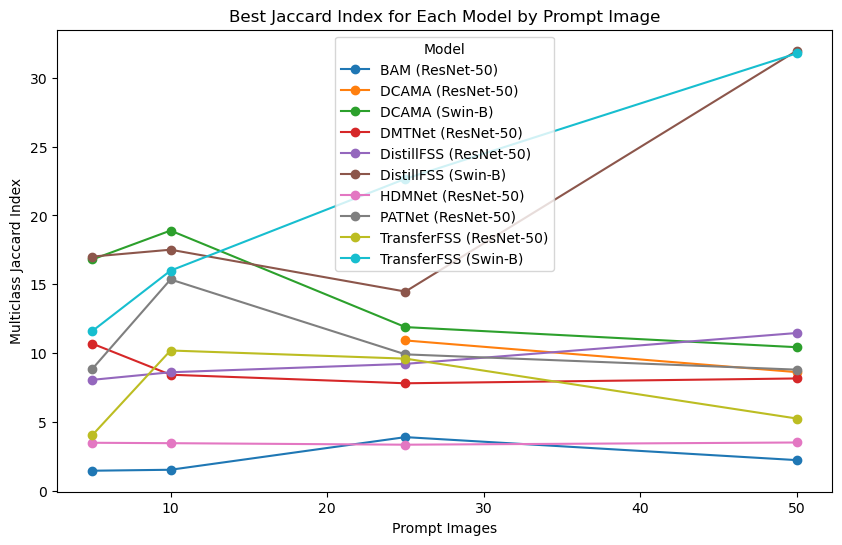

Support set lenght        5      10     25     50
Model       Backbone                             
BAM         ResNet-50   1.46   1.53   3.90   2.23
HDMNet      ResNet-50   3.49   3.46   3.35   3.51
PATNet      ResNet-50   8.85  15.35   9.91   8.80
DMTNet      ResNet-50  10.69   8.43   7.81   8.16
DCAMA       ResNet-50    NaN    NaN  10.92   8.62
            Swin-B     16.80  18.90  11.89  10.43
TransferFSS ResNet-50   4.04  10.19   9.60   5.25
            Swin-B     11.60  15.99  22.66  31.77
DistillFSS  ResNet-50   8.06   8.61   9.22  11.46
            Swin-B     17.01  17.51  14.47  31.96

In [20]:
pivot_df = get_results_and_fig(dataset, filtered_df, prompt_images_col)
pivots[dataset] = pivot_df
pivot_df

# LATEX

In [21]:
pivots["ISIC"]

Support set lenght        9      15     30     60
Model       Backbone                             
BAM         ResNet-50   9.67   8.34   8.47   8.69
HDMNet      ResNet-50   9.16   7.82   8.20   7.77
PATNet      ResNet-50  16.01  13.46  15.95  16.97
DMTNet      ResNet-50  15.00  15.07  15.55  17.35
DCAMA       ResNet-50   3.36   8.80   6.97   7.59
            Swin-B      8.67   7.25   7.22   7.72
TransferFSS ResNet-50   7.52  15.65  14.34  11.10
            Swin-B       NaN    NaN  12.97  20.96
DistillFSS  ResNet-50  11.24  12.48  12.36  12.22
            Swin-B     13.31  15.95  17.69  22.75

In [30]:
import pandas as pd

# Define the folder containing the CSV files
results_folder = "/home/pasquale/projects/FSSWeedMap/results"

# List of CSV files and their corresponding dataset names
csv_files = {
    "Pothole.csv": "Pothole",
    "WeedMap.csv": "WeedMap",
    "KVASIR.csv": "KVASIR",
    "ISIC.csv": "ISIC",
    "Nucleus.csv": "Nucleus",
    "LungCancer.csv": "LungCancer"
}

# Read each CSV file and add a row for the dataset name
dfs = []
for csv_file, dataset_name in csv_files.items():
    df = pd.read_csv(f"{results_folder}/{csv_file}")
    df = df.round(2)
    # Create a DataFrame with a single row for the dataset name
    dataset_row = pd.DataFrame([[dataset_name] + [""] * (df.shape[1] - 1)], columns=df.columns)
    # Concatenate the dataset row with the actual data
    df = pd.concat([dataset_row, df], ignore_index=True)
    dfs.append(df)

# Concatenate all DataFrames
concatenated_df = pd.concat(dfs, ignore_index=True)
concatenated_df = concatenated_df.fillna("--")
print(concatenated_df)
concatenated_df.to_csv(f"{results_folder}/ConcatenatedResults.csv", index=False)
concatenated_df

          Model   Backbone      5     10     25     50   9  15  30  60
0       Pothole                                         --  --  --  --
1           BAM  ResNet-50   1.46   1.53    3.9   2.23  --  --  --  --
2        HDMNet  ResNet-50   3.49   3.46   3.35   3.51  --  --  --  --
3        PATNet  ResNet-50   8.85  15.35   9.91    8.8  --  --  --  --
4        DMTNet  ResNet-50  10.69   8.43   7.81   8.16  --  --  --  --
..          ...        ...    ...    ...    ...    ...  ..  ..  ..  ..
59        DCAMA     Swin-B   0.18   0.27   0.21   0.18  --  --  --  --
60  TransferFSS  ResNet-50   8.51  13.69  22.24  24.28  --  --  --  --
61  TransferFSS     Swin-B    2.8   2.29   1.51   2.51  --  --  --  --
62   DistillFSS  ResNet-50   8.91   7.88  16.59  17.68  --  --  --  --
63   DistillFSS     Swin-B   3.16   0.51   2.48   4.87  --  --  --  --

[64 rows x 10 columns]


,Model,Backbone,5,10,25,50,9,15,30,60
0,Pothole,,,,,,--,--,--,--
1,BAM,ResNet-50,1.46,1.53,3.9,2.23,--,--,--,--
2,HDMNet,ResNet-50,3.49,3.46,3.35,3.51,--,--,--,--
3,PATNet,ResNet-50,8.85,15.35,9.91,8.8,--,--,--,--
4,DMTNet,ResNet-50,10.69,8.43,7.81,8.16,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...
59,DCAMA,Swin-B,0.18,0.27,0.21,0.18,--,--,--,--
60,TransferFSS,ResNet-50,8.51,13.69,22.24,24.28,--,--,--,--
61,TransferFSS,Swin-B,2.8,2.29,1.51,2.51,--,--,--,--
62,DistillFSS,ResNet-50,8.91,7.88,16.59,17.68,--,--,--,--


In [ ]:

# Generate LaTeX table
latex_table = concatenated_df.to_latex(index=False, header=True, na_rep='', escape=False, float_format="%.2f")

# Save the LaTeX table to a file
output_file = f"{results_folder}/ConcatenatedResults.tex"
with open(output_file, "w") as f:
    f.write(latex_table)

print(f"LaTeX table saved to {output_file}")